In [51]:
import numpy as np
import matplotlib.pyplot as plt

## Example Data

In [57]:
models = {
    'Data': ['BEHRT', '+Med', '+Full Vocab\n +Sex'],
    'Model': ['+Timestamps', '+time2vec(age)', '+RoPE(pos_ids)', 'trainable\nembeddings'],
    'Training': ['MR 25%', 'MR 30%', 'MR 35%']
}
#Specify which models should be hatched
groups = {
    'Data': slice(0, len(models['Data'])),
    'Model': slice(len(models['Data']), len(models['Data']) + len(models['Model'])),
    'Training': slice(len(models['Data'])+len(models['Model']), len(models['Data'])+len(models['Model'])+len(models['Training']))
}
models = [model for group in models.values() for model in group]

model_adapted = [False, False, False, 
                 False, False, False, True, 
                 False, False, False]

roc_scores_death = [0.86, 0.861, 0.862, 
              0.864, 0.865, 0.866, .863, 
              0.868, 0.869, 0.87]
roc_scores_pain = [.77, None, None, 
              0.776, 0.777, 0.778, .775,
              None, None, None]
roc_scores_infection = [.73, None, None,
                0.737, 0.739, 0.736, .732,
                None, None, None]
stds = [.002] * len(roc_scores_death)
stds_death = np.array(stds) + np.random.normal(0, 0.001, len(roc_scores_death))
stds_pain = np.array(stds) + np.random.normal(0, 0.001, len(roc_scores_pain))
stds_infection = np.array(stds) + np.random.normal(0, 0.001, len(roc_scores_infection))

## Figure

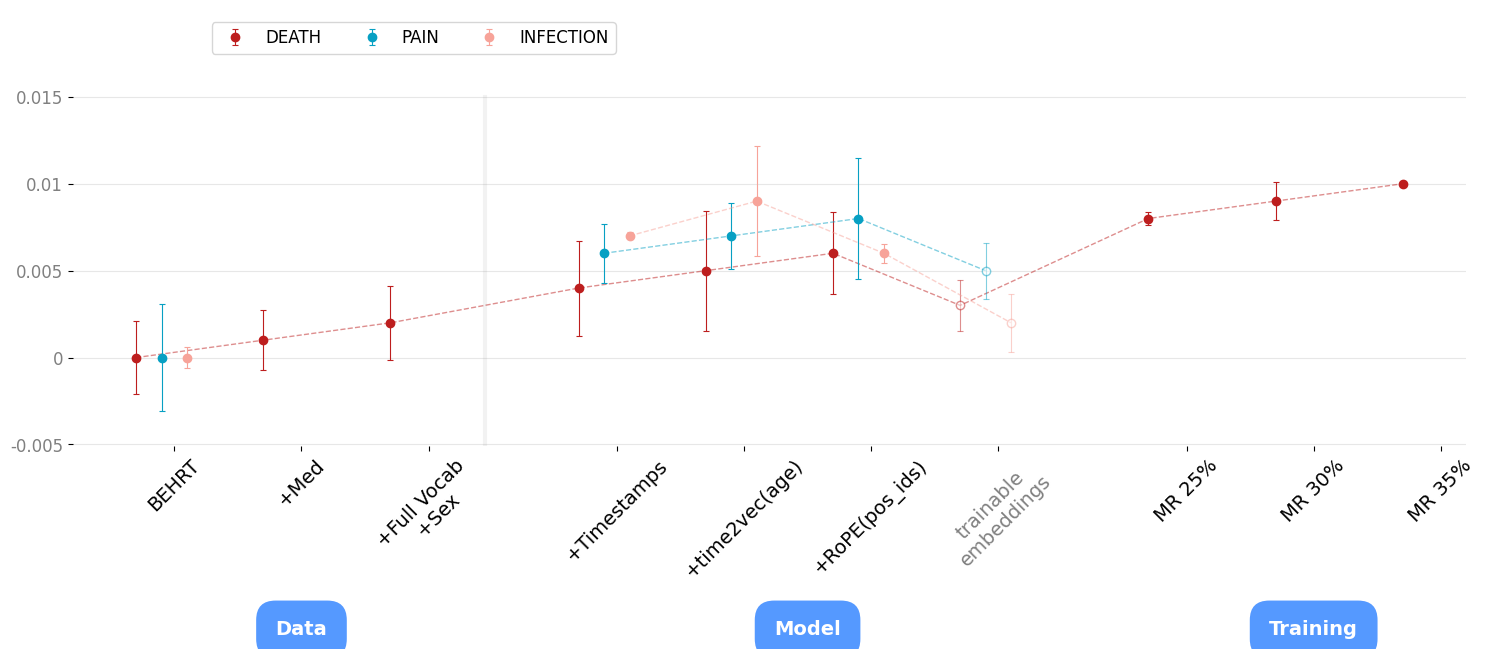

In [78]:
# Constants
FIGSIZE = (15, 7)
MODEL_DISTANCE = 0.25
GROUP_GAP = 0.6
DISEASE_GAP = 0.1
LEGEND_LOC = (0.1, .9)
GROUP_LABEL_PAD = 0.01
Y_LIM = (-.0051, .02)
BOX_COLORS = {'Data': "#5599FF", 'Model': "#5599FF", 'Training': "#5599FF"}

def normalize_scores(scores):
    """Normalize scores by subtracting the first score from all scores."""
    return [(score - scores[0]) if score is not None else None for score in scores]

def create_scatter_plot(ax, positions, scores, stds, label, color, faint):
    """Creates a scatter plot with error bars."""
    scores = normalize_scores(scores)
    for i, (pos, score, std, f) in enumerate(zip(positions, scores, stds, faint)):
        if score is not None:
            ax.errorbar(pos, score, yerr=std, markersize=6, fmt='o', capsize=2, capthick=0.8,
                        elinewidth=0.8, mfc='w' if f else color, mec=color, label=label if i == 4 else None,
                        color=color, alpha=0.5 if f else 1)

def set_spines_visibility(ax, visibility=False):
    """Sets the visibility of the plot spines."""
    for spine in ['right', 'top', 'bottom', 'left']:
        ax.spines[spine].set_visible(visibility)

def style_plot(ax, y_ticklabels):
    """Styles the plot."""
    set_spines_visibility(ax)
    ax.set_yticks(y_ticklabels)
    ax.set_yticklabels(y_ticklabels, color='grey', fontsize=12)
    ax.legend(loc=LEGEND_LOC, frameon=True, fontsize=12, ncol=4)
    ax.grid(False)
    ax.grid(axis='y', linestyle='-', alpha=0.3)

def create_line_plot(ax, positions, scores, color):
    """Creates a line plot."""
    scores = normalize_scores(scores)
    ax.plot(positions, scores, color=color, linestyle='--', linewidth=1, alpha=0.5)

def add_group_labels(ax, positions, labels, colors, y_position):
    """Adds group labels to the plot."""
    for pos, label in zip(positions, labels):
        ax.text(pos, y_position, label, ha='center', va='top', fontsize=14, fontweight='bold', color='white',
                bbox=dict(facecolor=colors[label], edgecolor='none', boxstyle='round,pad=1'))
def set_model_adapted_colors(ax, model_adapted):
    """Sets the colors of the x-tick labels based on model adaptation."""
    colors = ['grey' if adapted else 'black' for adapted in model_adapted]
    for xtick, color in zip(ax.get_xticklabels(), colors):
        xtick.set_color(color)
def initialize_plot(models, groups):
    """Initializes the plot with adjusted positions and group labels."""
    positions = np.arange(len(models))
    adjusted_positions = []
    group_labels = []
    group_label_positions = []
    offset = 0

    for group, indices in groups.items():
        group_size = indices.stop - indices.start
        for i in range(group_size):
            adjusted_positions.append(positions[indices.start + i] + offset)
            offset += MODEL_DISTANCE
        group_labels.append(group)
        group_label_positions.append(np.mean(adjusted_positions[-group_size:]))
        offset += GROUP_GAP  # Adding space after each group

    # Adjust the positions for plotting
    adjusted_positions = np.array(adjusted_positions) - 1.5 * MODEL_DISTANCE
    return adjusted_positions, group_labels, group_label_positions

def plot_data(ax, positions, model_adapted, scores,stds, colors):
    """Plots the data for each category."""
    for i, (category, color) in enumerate(colors.items()):
        category_scores = scores[category]
        category_stds = stds[category] 
        create_scatter_plot(ax, positions + i * MODEL_DISTANCE, category_scores, category_stds, category.upper(), color, model_adapted)
        create_line_plot(ax, positions + i * MODEL_DISTANCE, category_scores, color)

def main():
    # Your data initialization here
    fig, ax = plt.subplots(figsize=FIGSIZE)
    adjusted_positions, group_labels, group_label_positions = initialize_plot(models, groups)
    
    colors = {'death': '#BD1E1E', 'pain': '#07A0C3', 'infection': '#F7A399'}
    scores = {'death': roc_scores_death, 'pain': roc_scores_pain, 'infection': roc_scores_infection}
    stds = {'death': stds_death, 'pain':stds_pain, 'infection': stds_infection}
    plot_data(ax, adjusted_positions, model_adapted, scores, stds, colors)

    # Setting the x-ticks to be the diseases with adjusted positions
    ax.set_xticks(adjusted_positions + 1.5 * MODEL_DISTANCE)
    ax.set_xticklabels(models, fontsize=14, rotation=45, color='grey')
    set_model_adapted_colors(ax, model_adapted)

    ax.set_ylim(Y_LIM)
    y_ticklabels = [-.005, 0, .005, .01, .015]
    style_plot(ax, y_ticklabels)
    add_group_labels(ax, group_label_positions, group_labels, BOX_COLORS, Y_LIM[0] - GROUP_LABEL_PAD)
    plt.tight_layout()
    plt.show()
    
    #fig.savefig('roc_scores_comparison.png', dpi=300, bbox_inches='tight')

if __name__ == "__main__":
    main()
